#### Import Necessary Libraries
The following libraries are required for data processing, scaling, modeling, and evaluation.

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
pd.set_option('future.no_silent_downcasting', True)

#### 1. Load Data
We start by loading the `train.csv`, `test.csv`, and `store.csv` files. We will merge the `store.csv` with both the `train.csv` and `test.csv` datasets to include additional information about each store.

In [10]:
# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
store = pd.read_csv('store.csv')

# Merge train and store data
train = pd.merge(train, store, on='Store', how='left')
test = pd.merge(test, store, on='Store', how='left')

C:\Users\biement fanteye\AppData\Local\Temp\ipykernel_18952\3909476591.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('train.csv')


#### Handle Missing Values
Fill missing values in columns like `CompetitionDistance`, `Promo2SinceYear`, `Promo2SinceWeek`, and `PromoInterval`. The competition distance is filled with the median, while promo-related columns are filled with 0, assuming no promotion.

In [11]:
# Fill missing values in 'CompetitionDistance'
train['CompetitionDistance'] = train['CompetitionDistance'].fillna(train['CompetitionDistance'].median())
test['CompetitionDistance'] = test['CompetitionDistance'].fillna(test['CompetitionDistance'].median())

# Handle missing values in Promo2-related columns
train['Promo2SinceYear'] = train['Promo2SinceYear'].fillna(0)
train['Promo2SinceWeek'] = train['Promo2SinceWeek'].fillna(0)
train['PromoInterval'] = train['PromoInterval'].fillna(0)

test['Promo2SinceYear'] = test['Promo2SinceYear'].fillna(0)
test['Promo2SinceWeek'] = test['Promo2SinceWeek'].fillna(0)
test['PromoInterval'] = test['PromoInterval'].fillna(0)

#### Datetime Feature Extraction
Extract new features from the `Date` column, such as year, month, day, week of the year, day of the week, and whether it's a weekend or not.

In [12]:
# Convert Date to datetime format
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# Extract relevant datetime features
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['WeekOfYear'] = train['Date'].dt.isocalendar().week
train['DayOfWeek'] = train['Date'].dt.dayofweek
train['IsWeekend'] = train['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day
test['WeekOfYear'] = test['Date'].dt.isocalendar().week
test['DayOfWeek'] = test['Date'].dt.dayofweek
test['IsWeekend'] = test['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

#### Convert Categorical Columns
Convert categorical features like `StateHoliday`, `StoreType`, and `Assortment` into numeric format. For `StateHoliday`, map the holiday types into integers, and for `StoreType` and `Assortment`, use one-hot encoding.

In [13]:
# Convert StateHoliday, StoreType, Assortment to numeric using Label Encoding
train['StateHoliday'] = train['StateHoliday'].replace({'0': 0, 'a': 1, 'b': 2, 'c': 3}).astype(int)
test['StateHoliday'] = test['StateHoliday'].replace({'0': 0, 'a': 1, 'b': 2, 'c': 3}).astype(int)

# One-hot encode StoreType and Assortment
train = pd.get_dummies(train, columns=['StoreType', 'Assortment'], drop_first=True)
test = pd.get_dummies(test, columns=['StoreType', 'Assortment'], drop_first=True)

#### Feature Scaling
Use the `StandardScaler` to normalize numerical features like `CompetitionDistance`, `Promo2SinceYear`, and `Promo2SinceWeek` for better model performance.

In [14]:
# Select numerical features to scale
numerical_features = ['CompetitionDistance', 'Promo2SinceYear', 'Promo2SinceWeek']

scaler = StandardScaler()
train[numerical_features] = scaler.fit_transform(train[numerical_features])
test[numerical_features] = scaler.transform(test[numerical_features])

#### Building a Machine Learning Pipeline

In this section, we define a machine learning pipeline using `Pipeline` from `sklearn.pipeline`. The pipeline includes the following steps:
- **Scaling**: We use `StandardScaler` to normalize numerical features.
- **Modeling**: We use `RandomForestRegressor` to predict sales, setting the number of estimators to 100 and using a random seed for reproducibility.

We also split the dataset into training and validation sets before fitting the pipeline and making predictions. Finally, we calculate the model's performance using Mean Squared Error (MSE).

In [32]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import TransformerMixin

# Define a transformer for converting boolean columns to integers
class BooleanToInteger(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.astype(int)

# Categorical columns (boolean and other categorical)
categorical_cols = ['StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b', 'Assortment_c']
numerical_cols = ['CompetitionDistance', 'Promo2SinceYear', 'Promo2SinceWeek']  # Include numerical columns here

# Preprocessing for boolean columns
boolean_transformer = Pipeline(steps=[
    ('convert_bool', BooleanToInteger()),  # Convert bool to int
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical data
])

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing values
    ('scaler', StandardScaler())  # Scale numerical data
])

# Bundle preprocessing for both numerical and boolean data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('bool', boolean_transformer, categorical_cols)  # Boolean columns processing
    ])

# Define the full pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Separate features and target
X = train.drop(['Sales', 'Date'], axis=1)  # Drop the target and unneeded columns
y = train['Sales']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the validation set
y_pred = pipeline.predict(X_valid)

# Evaluate the model
mse = mean_squared_error(y_valid, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 10947924.795049373


#### Analyzing Feature Importance

After training the Random Forest model, we analyze the feature importance to understand which features are most relevant for predicting sales. We extract the feature importance values from the model and create a DataFrame that lists the features in order of importance, helping us gain insights into the model's decision-making process.

                Feature  Importance
0   CompetitionDistance    0.674754
1       Promo2SinceYear    0.067779
2       Promo2SinceWeek    0.061350
3         StoreType_b_0    0.037081
4         StoreType_b_1    0.035739
5         StoreType_c_0    0.022623
6         StoreType_c_1    0.022284
12       Assortment_c_1    0.021817
11       Assortment_c_0    0.019396
7         StoreType_d_0    0.018624
8         StoreType_d_1    0.018510
10       Assortment_b_1    0.000022
9        Assortment_b_0    0.000021


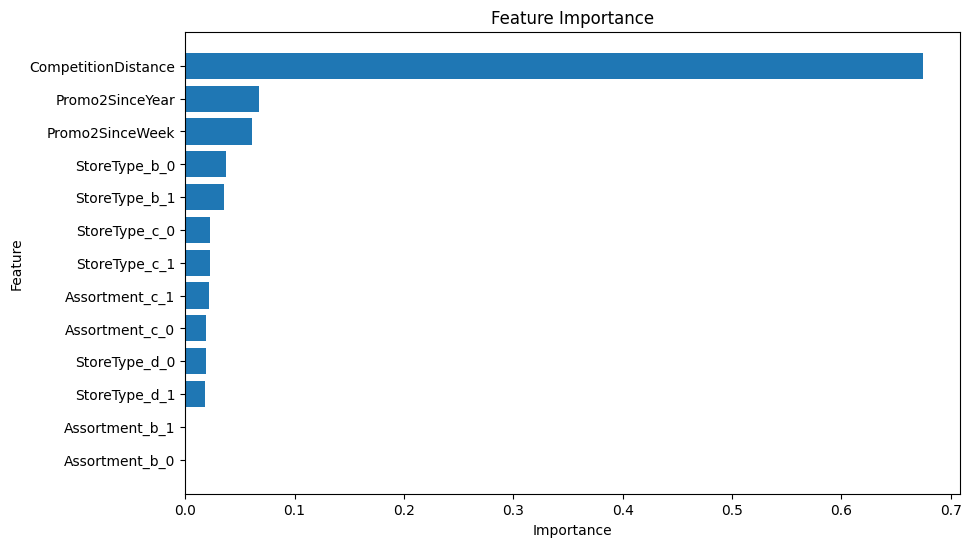

In [39]:
import matplotlib.pyplot as plt
# import numpy as np

# Get the feature names after transformation
preprocessed_columns = numerical_cols + \
    list(pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols))

# Access feature importance from the model inside the pipeline
importances = pipeline.named_steps['model'].feature_importances_

# Create a dataframe for feature importances
feature_importances = pd.DataFrame({'Feature': preprocessed_columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()

#### Save the Model

This code snippet saves the trained machine learning model along with its preprocessing pipeline using the `joblib` library. A unique filename is created based on the current timestamp to ensure each model is easily identifiable.

The following code implements this process:


In [40]:
import joblib
from datetime import datetime

# Get the current date and time to create a timestamp
timestamp = datetime.now().strftime('%d-%m-%Y-%H-%M-%S-%f')

# Define the filename with the timestamp
model_filename = f'model-{timestamp}.pkl'

# Serialize the pipeline (model + preprocessor)
joblib.dump(pipeline, model_filename)

print(f'Model saved as: {model_filename}')

Model saved as: model-24-09-2024-18-59-21-441214.pkl
